# *Insight*-HXMT 相位分解谱处理示例
## ——[概览](#概览)、[数据预处理](#数据预处理)、[计时分析](#计时分析)、[能谱分析](#能谱分析)

庹攸隶 (tuoyl@ihep.ac.cn)
##### 最终结果：使用慧眼一次 Crab 的观测数据，产生 Crab 脉冲星的相位分解谱

## 概览
### 准备工作
该 Jupyter 文本使用 Python3 环境，若想执行以下所有命令，需要做这些准备：
* 安装并初始化 HXMTDAS 环境（例如能在终端中运行```hepical```命令）
* 使用 Python3.* 版本，并安装有 astropy, numpy, matplotlib 模块
    （若使用 conda 环境，请在 environment.yml 文件所在路径执行 ``` conda env create -f environment.yml ``` 安装名为 hxmt_analysis 的环境，然后执行 ```conda activate hxmt_analysis```
    <div class="alert alert-block alert-info">
<b>NOTES
    :</b> 该介绍中涉及到的命令，你可以在 Jupyter 中使用 Shift+Enter 逐条执行。你同时完全可以在终端中执行所有命令。
</div>

该 Jupyter notebook 将放在 https://github.com/tuoyl/hxmt_analysis_demo 托管更新，你可以下载到文中涉及到的 Python 脚本。你也可以使用 pip 下载一个名为 hxmt-analysis-demo 的模块 ```python -m pip install --index-url https://test.pypi.org/simple/ --no-deps hxmt-analysis-demo```，该模块中同样包含了这些脚本。
### 目标
* **数据预处理**：使用慧眼用户处理软件（HXMTDAS v2.01）产生用于分析的数据产品
* **计时分析**：使用 Crab 的星历（ephemeris）产生 Crab 的脉冲轮廓
* **能谱分析**：对轮廓分成多个相位区间，得到各个区间的能谱及背景能谱

## 数据预处理
数据预处理针对三个载荷高能、中能和低等载荷，分别是：
* [高能载荷(HE)数据处理](#高能载荷(HE)数据处理)
* [中能载荷(ME)数据处理](#中能载荷(ME)数据处理)
* [低能载荷(LE)数据处理](#低能载荷(LE)数据处理)

### 高能载荷(HE)数据处理
### hepical

In [4]:
!hepical evtfile=./data/HE/HXMT_P010129900101_HE-Evt_FFFFFF_V1_L1P.FITS outfile=./data/HE/he_pi.fits clobber=yes

hepical : ##############################################
hepical : HXMT HE task, hepical is running
hepical : PILParSet Warning: parameter 'clobber' set to yes!
hepical : PILParSet Warning: the file ./data/HE/he_pi.fits will be overwritten!
hepical : HxmtCaldb Error: There are not files that satisfied the selection criteria!
hepical : HxmtCaldb Error: 'Telescope' HXMT 'instrument' HE 'detname' NONE 'filter' NONE 'codename' CHAN2PI_0' 
hepical : hepical: Error: Unable to get 'gain (codename:CHAN2PI_0)' file named ''!
hepical : HXMT HE task, hepical is running unsuccessfully!
hepical : ##############################################


<div class="alert alert-block alert-warning">
<b>NOTES:</b> 若出现报错 hepical : hepical: Error: Unable to get 'gain (codename:CHAN2PI_0)' file named ''! 则根据 CALDB 中 gainfile 的路径手动指定，执行如下命令。
</div>

In [7]:
!hepical evtfile=./data/HE/HXMT_P010129900101_HE-Evt_FFFFFF_V1_L1P.FITS gainfile=/Users/tuoyouli/Documents/hxmtsoft_newtest/CALDB/data/hxmt/he/bcf/hxmt_he_gain_20171030_v1.fits outfile=./data/HE/he_pi.fits clobber=yes

hepical : ##############################################
hepical : HXMT HE task, hepical is running
[####################################################################################################][100%]
hepical : HXMT HE task, all events from raw evt file is 145630697!
hepical : HXMT HE task, glitch removal events is 636135!
hepical : HXMT HE task, hepical is running successfully!
hepical : ##############################################


运行该命令根据不同的计算机性能，通常会占用你2-3分钟的时间。输出产生一个新的事例文件，命名为 he_pi.fits。

In [8]:
!ls -trl ./data/HE/

total 9658648
-rwx------  1 tuoyouli  staff     1143360 Aug 19 15:31 HXMT_P010129900101_HE-HV_FFFFFF_V1_L1P.FITS
-rwx------  1 tuoyouli  staff      469440 Aug 19 15:31 HXMT_P010129900101_HE-DTime_FFFFFF_V1_L1P.FITS
-rwx------  1 tuoyouli  staff      109440 Aug 19 15:31 HXMT_P010129900101_HE-PM_FFFFFF_V1_L1P.FITS
-rwx------  1 tuoyouli  staff     1673280 Aug 19 15:31 HXMT_P010129900101_HE-TH_FFFFFF_V1_L1P.FITS
-rw-r--r--  1 tuoyouli  staff  2330262720 Aug 19 15:31 HXMT_P010129900101_HE-Evt_FFFFFF_V1_L1P.FITS
-rwx------  1 tuoyouli  staff      149760 Aug 19 15:31 HXMT_P010129900101_HE-InsStat_FFFFFF_V1_L1P.FITS
-rw-r--r--  1 tuoyouli  staff  2610072000 Aug 19 20:18 he_pi.fits


### hegtigen
生成 HE 载荷的好时间文件（GTIs）

In [11]:
!hegtigen hvfile=./data/HE/HXMT_P010129900101_HE-HV_FFFFFF_V1_L1P.FITS tempfile=./data/HE/HXMT_P010129900101_HE-TH_FFFFFF_V1_L1P.FITS ehkfile=./data/AUX/HXMT_P010129900101_HE-EHK_FFFFFF_V1_L1P.FITS outfile=./data/HE/he_gti.fits defaultexpr="NONE" expr="ELV>10&&COR>8&&T_SAA>=300&&TN_SAA>=300&&ANG_DIST<=0.04" clobber=yes

hegtigen : ##############################################
hegtigen : HXMT HE task, hegtigen is running
hegtigen : PILParSet Warning: parameter 'clobber' set to yes!
hegtigen : PILParSet Warning: the file ./data/HE/he_gti.fits will be overwritten!
hegtigen : HXMT HE task, hegtigen is running successfully!
hegtigen : ##############################################


我们推荐的对于涉及到能谱分析的好时间判选条件为```ELV>10&&COR>8&&T_SAA>=300&&TN_SAA>=300&&ANG_DIST<=0.04```。
同样的，你可以查看输出文件，我们这一步产生了一个命名为 he_gti.fits 的 FITS 文件。

In [12]:
!ls -trl ./data/HE/

total 9658688
-rwx------  1 tuoyouli  staff     1143360 Aug 19 15:31 HXMT_P010129900101_HE-HV_FFFFFF_V1_L1P.FITS
-rwx------  1 tuoyouli  staff      469440 Aug 19 15:31 HXMT_P010129900101_HE-DTime_FFFFFF_V1_L1P.FITS
-rwx------  1 tuoyouli  staff      109440 Aug 19 15:31 HXMT_P010129900101_HE-PM_FFFFFF_V1_L1P.FITS
-rwx------  1 tuoyouli  staff     1673280 Aug 19 15:31 HXMT_P010129900101_HE-TH_FFFFFF_V1_L1P.FITS
-rw-r--r--  1 tuoyouli  staff  2330262720 Aug 19 15:31 HXMT_P010129900101_HE-Evt_FFFFFF_V1_L1P.FITS
-rwx------  1 tuoyouli  staff      149760 Aug 19 15:31 HXMT_P010129900101_HE-InsStat_FFFFFF_V1_L1P.FITS
-rw-r--r--  1 tuoyouli  staff  2610072000 Aug 19 20:18 he_pi.fits
-rw-r--r--  1 tuoyouli  staff       17280 Aug 19 20:19 he_gti.fits


### hescreen
根据 GTIs 选择出符合要求的好事例

In [1]:
!hescreen evtfile=./data/HE/he_pi.fits gtifile=./data/HE/he_gti.fits outfile=./data/HE/he_screen.fits userdetid=0-17 minPI=0 maxPI=255 clobber=yes

hescreen : ##############################################
hescreen : HXMT HE task, hescreen is running
hescreen : PILParSet Warning: parameter 'clobber' set to yes!
hescreen : PILParSet Warning: the file ./data/HE/he_screen.fits will be overwritten!
hescreen : hescreen: User detector selection:
hescreen : HxmtBadDetector Info: there is no bad detector!
[####################################################################################################][100%]
hescreen : HEScreen task: 
hescreen : Detector ID '0' has event number :237400
hescreen : Detector ID '1' has event number :244273
hescreen : Detector ID '2' has event number :263201
hescreen : Detector ID '3' has event number :247841
hescreen : Detector ID '4' has event number :236576
hescreen : Detector ID '5' has event number :242721
hescreen : Detector ID '6' has event number :252674
hescreen : Detector ID '7' has event number :237050
hescreen : Detector ID '8' has event number :261260
hescreen : Detector ID '9' has event numb

运行 hescreen 命令大约会占用你1分钟时间，输出文件为 he_screen.fits。我们这里选择了探测器编号0-17，即全选，选择了能道0-255，也是全选。如果你选择产生不同能段的光子，则可以修改 minPI 和 maxPI 的值。

### hespecgen 
生成能谱文件（spectra）

In [1]:
!hespecgen evtfile=./data/HE/he_screen.fits outfile=./data/HE/he_spec deadfile=./data/HE/HXMT_P010129900101_HE-DTime_FFFFFF_V1_L1P.FITS userdetid="0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17" starttime=0 stoptime=0 minPI=0 maxPI=255 clobber=yes

hespecgen : HXMT HE task, hespecgen is running
hespecgen : hespecgen: User detector selection:
[####################################################################################################][100%]
hespecgen : HXMT HE task, hespecgen is running successfully!
hespecgen : ##############################################


我们在这一步生成了 HE 的18个探测器的能谱，通过 userdetid 参数选择探测器。使用分号(;)将各个探测器编号做分割，使我们产生了18个能谱，而不是18个探测器的总能谱。可以查看一下我们产生的结果，是18个以```he_spec```为前缀的```.pha```文件。能谱的结果可以在[能谱分析](#能谱分析)一节查看，这里暂不做展开。

In [6]:
!ls -tr ./data/HE/

HXMT_P010129900101_HE-HV_FFFFFF_V1_L1P.FITS	  he_spec_g4_4.pha
HXMT_P010129900101_HE-DTime_FFFFFF_V1_L1P.FITS	  he_spec_g3_3.pha
he_pi.fits					  he_spec_g2_2.pha
he_gti.fits					  he_spec_g17_17.pha
HXMT_P010129900101_HE-PM_FFFFFF_V1_L1P.FITS	  he_spec_g16_16.pha
he_screen.fits					  he_spec_g15_15.pha
HXMT_P010129900101_HE-TH_FFFFFF_V1_L1P.FITS	  he_spec_g14_14.pha
HXMT_P010129900101_HE-InsStat_FFFFFF_V1_L1P.FITS  he_spec_g13_13.pha
HXMT_P010129900101_HE-Evt_FFFFFF_V1_L1P.FITS	  he_spec_g12_12.pha
he_spec_g9_9.pha				  he_spec_g1_1.pha
he_spec_g8_8.pha				  he_spec_g11_11.pha
he_spec_g7_7.pha				  he_spec_g10_10.pha
he_spec_g6_6.pha				  he_spec_g0_0.pha
he_spec_g5_5.pha


<div class="alert alert-block alert-info">
<b>NOTES:</b> 我们之所以要产生18个能谱而不是一个总谱，是由于各个探测器的响应矩阵不一样，我们在之后会根据各个探测器的能谱产生其各自的响应（盲探测器不产生）。最后可以使用脚本 hhe_spec2pi 将能谱和响应矩阵合并。
</div>

In [1]:
!ls ./data/HE/he_spec*.pha | sort -V > ./data/HE/he_spec.txt
!cat ./data/HE/he_spec.txt

./data/HE/he_spec_g0_0.pha
./data/HE/he_spec_g1_1.pha
./data/HE/he_spec_g2_2.pha
./data/HE/he_spec_g3_3.pha
./data/HE/he_spec_g4_4.pha
./data/HE/he_spec_g5_5.pha
./data/HE/he_spec_g6_6.pha
./data/HE/he_spec_g7_7.pha
./data/HE/he_spec_g8_8.pha
./data/HE/he_spec_g9_9.pha
./data/HE/he_spec_g10_10.pha
./data/HE/he_spec_g11_11.pha
./data/HE/he_spec_g12_12.pha
./data/HE/he_spec_g13_13.pha
./data/HE/he_spec_g14_14.pha
./data/HE/he_spec_g15_15.pha
./data/HE/he_spec_g16_16.pha
./data/HE/he_spec_g17_17.pha


### herspgen
产生除盲探测器外，所有探测器各自的响应矩阵

In [1]:
phalist = open("./data/HE/he_spec.txt")
for phafile,i in zip(phalist,range(18)):
    if i == 16:continue # 16号盲探测器不产生响应矩阵
    herspgen_text = "herspgen phafile=%s outfile=./data/HE/he_rsp_g%s.fits attfile=%s ra=-1 dec=-91 clobber=yes"%(phafile[0:-1], str(i), "./data/ACS/HXMT_P010129900101_Att_FFFFFF_V1_L1P.FITS")
    !{herspgen_text}
phalist.close()

herspgen : HXMT HE task, herspgen is running
herspgen : HERspGen: Attitude and Alignment correction of detector '0'  is 0.985351 !
herspgen : HXMT HE task, herspgen is running successfully!
herspgen : ##############################################
herspgen : HXMT HE task, herspgen is running
herspgen : HERspGen: Attitude and Alignment correction of detector '1'  is 0.980126 !
herspgen : HXMT HE task, herspgen is running successfully!
herspgen : ##############################################
herspgen : HXMT HE task, herspgen is running
herspgen : HERspGen: Attitude and Alignment correction of detector '2'  is 0.995052 !
herspgen : HXMT HE task, herspgen is running successfully!
herspgen : ##############################################
herspgen : HXMT HE task, herspgen is running
herspgen : HERspGen: Attitude and Alignment correction of detector '3'  is 0.980126 !
herspgen : HXMT HE task, herspgen is running successfully!
herspgen : ##############################################
herspgen

我们产生了17个探测器的响应矩阵。可以查看产生的结果

In [4]:
!ls -tr ./data/HE//he_rsp*

./data/HE//he_rsp_g0.fits  ./data/HE//he_rsp_g9.fits
./data/HE//he_rsp_g1.fits  ./data/HE//he_rsp_g10.fits
./data/HE//he_rsp_g2.fits  ./data/HE//he_rsp_g11.fits
./data/HE//he_rsp_g3.fits  ./data/HE//he_rsp_g12.fits
./data/HE//he_rsp_g4.fits  ./data/HE//he_rsp_g13.fits
./data/HE//he_rsp_g5.fits  ./data/HE//he_rsp_g14.fits
./data/HE//he_rsp_g6.fits  ./data/HE//he_rsp_g15.fits
./data/HE//he_rsp_g7.fits  ./data/HE//he_rsp_g17.fits
./data/HE//he_rsp_g8.fits


### 中能载荷(ME)数据处理

### mepical
ME 探测器的 Pulse Invariance CALibration。
输入的两个文件，```evtfile=``` 输入的是原始的事例文件（文件名的关键字是```ME-Evt```），```tempfile``` 是温度文件（文件名的关键字是```ME-TH```）

In [1]:
!mepical evtfile=./data/ME/HXMT_P010129900101_ME-Evt_FFFFFF_V1_L1P.FITS tempfile=./data/ME/HXMT_P010129900101_ME-TH_FFFFFF_V1_L1P.FITS outfile=./data/ME/me_pi.fits clobber=yes

mepical : ##############################################
mepical : HXMT ME task, mepical is running
[####################################################################################################][100%]
mepical : HXMT ME task, mepical is running successfully!
mepical : ##############################################


我们可以查看新产生的文件

In [4]:
!ls -l ./data/ME/me_pi.fits

-rw-r--r--  1 tuoyouli  staff  2267202240 Aug 23 21:29 ./data/ME/me_pi.fits


### megrade
对 ME 的事例进行分级，并挑选“单分裂”事例。同时可以产生 ME 的死时间文件。```evtfile``` 是输入的文件名，该文件是上一步 ```mepical``` 输出产生的文件。```outfile``` 和 ```deadfile``` 分别为输出的完成事例挑选的文件名和输出的死时间文件的文件名。

In [5]:
!megrade evtfile=./data/ME/me_pi.fits outfile=./data/ME/me_grade.fits deadfile=./data/ME/me_dtime.fits clobber=yes

megrade : ##############################################
megrade : HXMT ME task, megrade is running
[####################################################################################################][100%]
megrade : HXMT ME task, megrade is running successfully!
megrade : ##############################################


### megtigen
产生 ME 探测器对应的好时间文件。好时间的判选条件和 HE 的选择条件相同，为```ELV>10&&COR>8&&T_SAA>=300&&TN_SAA>=300&&ANG_DIST<=0.04```

In [1]:
!megtigen tempfile=./data/ME/HXMT_P010129900101_ME-TH_FFFFFF_V1_L1P.FITS ehkfile=./data/AUX/HXMT_P010129900101_HE-EHK_FFFFFF_V1_L1P.FITS outfile=./data/ME/me_gti.fits defaultexpr="NONE" expr="ELV>10&&COR>8&&T_SAA>=300&&TN_SAA>=300&&ANG_DIST<=0.04" clobber=yes

megtigen : ##############################################
megtigen : HXMT ME task, megtigen is running
megtigen : PILParSet Warning: parameter 'clobber' set to yes!
megtigen : PILParSet Warning: the file ./data/ME/me_gti.fits will be overwritten!
megtigen : HXMT ME task, megtigen is running successfully!
megtigen : ##############################################


我们可以查看，产生了一个命名为 me_gti.fits 的文件

In [1]:
!ls ./data/ME//me_gti.fits

./data/ME//me_gti.fits


### megti
使用 megti.py 脚本，可以进一步筛选GTIs。在上一步产生的 GTI 文件的基础上，去除掉粒子本底影响较大的时间段。我们可以使用```-h```参数查看该脚本的运行方式。

In [2]:
!python ./hxmt_scripts/megti.py -h

('----------', 'import end', '----------')
*********************************************************
*********************************************************
*********************************************************
************ PRINT: megti -h for usage   *************
*********************************************************
Method 1: megti megrade.fits oldgti.fits newgti.fits
Method 2: Using interactive method in prompt.


这里提供两种输入方式：Method 1 是在命令行按顺序输入 ```megrade``` 的输出文件、```megtigen``` 的输出文件，和新的 GTI 文件的文件名；Method 2 是使用交互式运行，在执行 ```megti``` 后会提示你输入上述文件。我们以第一种执行方式为例进行演示。

<div class="alert alert-block alert-info">
<b>NOTES:</b> 我们在这里提供该脚本，放置在 hxmt_scripts 文件夹下，故执行该脚本的方式为 python megti.py 需要注意的是，通过慧眼的软件下载网页，你能在下载的软件包中获得同样的脚本，不过在安装说明中，你可能已经设置了shell 环境的”别名“，即在shell中运行 megti 命令等效于上述的运行 megti.py 脚本。两种运行方式没有区别，我这里因为 Jupyter 不识别shell的别名，故直接执行python脚本，但本质上二者没有区别。
</div>

In [3]:
!python ./hxmt_scripts/megti.py ./data/ME/me_grade.fits ./data/ME/me_gti.fits ./data/ME/me_gti_new.fits

('----------', 'import end', '----------')
*********************************************************
*********************************************************
*********************************************************
************ PRINT: megti -h for usage   *************
*********************************************************
(array([1.78432393e+08, 1.78433313e+08, 1.78433360e+08, 1.78433467e+08,
       1.78438215e+08, 1.78439098e+08, 1.78439107e+08, 1.78439111e+08,
       1.78439115e+08, 1.78444099e+08]), array([1.78433299e+08, 1.78433340e+08, 1.78433419e+08, 1.78433780e+08,
       1.78439097e+08, 1.78439106e+08, 1.78439109e+08, 1.78439113e+08,
       1.78439462e+08, 1.78444844e+08]))
chooseing the gradedata in the input gtifile
(29385504, 29385504)
('median==', -31.215000000000032)
('loop1', 'median=', -31.215000000000032, 'Dmedian=', 1000031.215)
('median==', -31.215000000000032)
('loop2', 'median=', -31.215000000000032, 'Dmedian=', 0.0)
[904.  58. 312. 881. 346. 521. 212.]
done


我们可以查看产生的新的 GTI 文件，命名为 me_gti_new.fits

In [2]:
!ls -1t ./data/ME/me_gti*

./data/ME/me_gti_new.fits
./data/ME/me_gti.fits


### mescreen
接下来，我们根据 GTIs 可以筛选出该好时间段内的事例。同时我们根据探测器编号、能道、观测时间等做更严格的筛选。根据标定的情况，我们只需要选择所有”小视场“的探测器和”盲探测器“。

我们提供了一个 Python 的小工具```hprint_detid.py```，可以输出所有探测器的编号，我们在筛选之前可以先输出各个探测器的信息，找出我们需要的ME小视场的探测器。

In [5]:
!python ./hxmt_scripts/hprint_detid.py 

*********** Detector ID catalogue ***********
--------------------------
--------------------------

HE detector ID for SMALL FOV (5.7x1.1):
0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 17

HE BLIND detector ID:
16

HE SMALL FOV information (5.7x1.1):
FOV   0: 1, 3, 8, 11, 12
FOV -60: 0, 4, 7,  9, 14, 17
FOV +60: 2, 5, 6, 10, 13, 15

HE LARGE FOV information (5.7x5.7):
2, 9
--------------------------
--------------------------

ME ASIC ID for SMALL FOV (1x4):
0-5, 7, 12-23, 25, 30-41, 43, 48-53

ME BLIND ASIC ID:
10, 28, 46

ME ASIC ID with calibration source:
6, 11, 24, 29, 42, 47

ME SMALL FOV information (1x4):
FOV 0:   0-5,  7, 12-17
FOV 1: 18-23, 25, 30-35
FOV 2: 36-41, 43, 48-53

ME LARGE FOV information (4x4):
8, 9, 26, 27, 44, 45
--------------------------
--------------------------

LE detector ID for SMALL FOV (1.6x6):
0,2-4,6-10,12,14,20,22-26,28,30,32,34-36,38-42,44,46,52,54-58,60-62,64,66-68,70-74,76,78,84,86,88-90,92-94

LE BLIND detector ID for SMALL FOV:
13, 45, 77



可以看到，ME 探测器小视场（small FoV）对应的编号为 0-5, 7, 12-23, 25, 30-41, 43, 48-53。我们可以继续筛选事例。```mescreen``` 有一个输入参数 ```userdetid``` 即探测器编号。这个参数的值我们选择所有小视场探测器编号，即盲探测器的编号，```userdetid="0-5,7,12-23,25,30-41,43,48-53;10,28,46"``` 。 ```mescreen``` 的具体使用方式如下

In [6]:
!mescreen evtfile=./data/ME/me_grade.fits gtifile=./data/ME/me_gti.fits outfile=./data/ME/me_screen.fits userdetid="0-5,7,12-23,25,30-41,43,48-53;10,28,46" clobber=yes 

mescreen : ##############################################
mescreen : HXMT ME task, mescreen is running
mescreen : PILParSet Warning: parameter 'clobber' set to yes!
mescreen : PILParSet Warning: the file ./data/ME/me_screen.fits will be overwritten!
mescreen : mescreen: User detector selection:
mescreen : Bad (Bad,hot,flickening) detector List:
mescreen :        ID:  1
mescreen :        ID:  6
mescreen :        ID:  8
mescreen :        ID:  9
mescreen :        ID:  14
mescreen :        ID:  15
mescreen :        ID:  16
mescreen :        ID:  17
mescreen :        ID:  18
mescreen :        ID:  19
mescreen :        ID:  20
mescreen :        ID:  28
mescreen :        ID:  30
mescreen :        ID:  31
mescreen :        ID:  32
mescreen :        ID:  33
mescreen :        ID:  48
mescreen :        ID:  96
mescreen :        ID:  97
mescreen :        ID:  161
mescreen :        ID:  186
mescreen :        ID:  187
mescreen :        ID:  188
mescreen :        ID:  189
mescreen :        ID:  190
m

[####################################################################################################][100%]
mescreen : MEScreen task: 
mescreen : Detector ID '0' has event number :30675
mescreen : Detector ID '1' has event number :47373
mescreen : Detector ID '2' has event number :51318
mescreen : Detector ID '3' has event number :48772
mescreen : Detector ID '4' has event number :52885
mescreen : Detector ID '5' has event number :38759
mescreen : Detector ID '7' has event number :37019
mescreen : Detector ID '10' has event number :20294
mescreen : Detector ID '12' has event number :44241
mescreen : Detector ID '13' has event number :43148
mescreen : Detector ID '14' has event number :43662
mescreen : Detector ID '15' has event number :43319
mescreen : Detector ID '16' has event number :54026
mescreen : Detector ID '17' has event number :48136
mescreen : Detector ID '18' has event number :51227
mescreen : Detector ID '19' has event number :35722
mescreen : Detector ID '20' has event n

我们输出了一个命名为 me_screen.fits 的FITS文件。

In [3]:
!ls ./data/ME/me_screen.fits

./data/ME/me_screen.fits


### mespecgen
产生能谱文件。我们对 me_screen.fits 文件中事例，产生其能谱。me_screen.fits 中包含了”小视场“探测器的光子以及”盲探测器“的光子，我们产生能谱的时候，只产生”小视场“探测器的光子。在选择探测器时 ```userdetid="0-5,7,12-23,25,30-41,43,48-53"```。注意这里没有“盲探测器”对应的编号 10,28,46

In [7]:
!mespecgen evtfile=./data/ME/me_screen.fits outfile=./data/ME/me_spec deadfile=./data/ME/me_dtime.fits userdetid="0-5,7,12-23,25,30-41,43,48-53" clobber=yes

mespecgen : HXMT ME task, mespecgen is running
mespecgen : mespecgen: User detector selection:
[####################################################################################################][100%]
mespecgen : PILParSet Warning: parameter 'clobber' set to yes!
mespecgen : PILParSet Warning: the file ./data/ME/me_spec_g0_0-53.pha will be overwritten!
mespecgen : HXMT ME task, mespecgen is running successfully!
mespecgen : ##############################################


In [8]:
!ls ./data/ME/me_spec* 

./data/ME/me_spec_g0_0-53.pha


### merspgen
产生 ME 的响应矩阵

In [9]:
!merspgen phafile=./data/ME/me_spec_g0_0-53.pha outfile=./data/ME/me_rsp.fits attfile=./data/ACS/HXMT_P010129900101_Att_FFFFFF_V1_L1P.FITS ra=-1 dec=-91 clobber=yes

merspgen : HXMT ME task, merspgen is running
merspgen : PILParSet Warning: parameter 'clobber' set to yes!
merspgen : PILParSet Warning: the file ./data/ME/me_rsp.fits will be overwritten!
merspgen : MERspGen: detector id '0' will use common ARF!
merspgen : MERspGen: detector id '0' will use common RMF!
merspgen : MERspGen: Attitude and Alignment correction of detector '0'  is 0.979575 !
merspgen : MERspGen: detector id '1' will use common ARF!
merspgen : MERspGen: detector id '1' will use common RMF!
merspgen : MERspGen: Attitude and Alignment correction of detector '1'  is 0.979575 !
merspgen : MERspGen: detector id '2' will use common ARF!
merspgen : MERspGen: detector id '2' will use common RMF!
merspgen : MERspGen: Attitude and Alignment correction of detector '2'  is 0.979575 !
merspgen : MERspGen: detector id '3' will use common ARF!
merspgen : MERspGen: detector id '3' will use common RMF!
merspgen : MERspGen: Attitude and Alignment correction of detector '3'  is 0.979575 !
mer

In [10]:
!ls ./data/ME/me_rsp.fits

./data/ME/me_rsp.fits


### 低能载荷(LE)数据处理

### lepical
LE 探测器的 Pulse Invariance CALibration

In [2]:
!lepical evtfile=./data/LE/HXMT_P010129900101_LE-Evt_FFFFFF_V1_L1P.FITS tempfile=./data/LE/HXMT_P010129900101_LE-TH_FFFFFF_V1_L1P.FITS outfile=./data/LE/le_pi.fits

lepical : ##############################################
lepical : HXMT LE task, lepical is running
[####################################################################################################][100%]
lepical : HXMT LE task, lepical is running successfully!
lepical : ##############################################


产生了一个命名为 le_pi.fits 的事例文件。可以查看新产生的文件

In [13]:
!ls ./data/LE/le_pi.fits

./data/LE/le_pi.fits


### lerecon
LE 探测器的事例重建

In [14]:
!lerecon evtfile=./data/LE/le_pi.fits outfile=./data/LE/le_recon.fits instatusfile=./data/LE/HXMT_P010129900101_LE-InsStat_FFFFFF_V1_L1P.FITS

lerecon : ##############################################
lerecon : HXMT LE task, lerecon is running
lerecon : PILParSet Warning: parameter 'clobber' set to yes!
lerecon : PILParSet Warning: the file ./data/LE/le_recon.fits will be overwritten!
[####################################################################################################][100%]
lerecon : HXMT LE task, lerecon is running successfully!
lerecon : ##############################################


### legtigen
产生 LE 探测器的好时间(GTIs)文件。我们推荐的好时间为```expr="ELV>10&&COR>8&&DYE_ELV>40&&T_SAA>=300&&TN_SAA>=300&&ANG_DIST<=0.04"```，注意和 HE 与 ME 的好时间判选条件比起来，多了一个亮地球与卫星指向的夹角(DYE_ELV)大于40度的限制。

In [15]:
!legtigen evtfile="" instatusfile=./data/LE/HXMT_P010129900101_LE-InsStat_FFFFFF_V1_L1P.FITS tempfile=./data/LE/HXMT_P010129900101_LE-TH_FFFFFF_V1_L1P.FITS ehkfile=./data/AUX/HXMT_P010129900101_HE-EHK_FFFFFF_V1_L1P.FITS outfile=./data/LE/le_gti.fits defaultexpr="NONE" expr="ELV>10&&COR>8&&DYE_ELV>40&&T_SAA>=300&&TN_SAA>=300&&ANG_DIST<=0.04" clobber=yes

legtigen : ##############################################
legtigen : HXMT LE task, legtigen is running
legtigen : PILParSet Warning: parameter 'clobber' set to yes!
legtigen : PILParSet Warning: the file ./data/LE/le_gti.fits will be overwritten!
legtigen : legtigen: Warning: Unable to get 'EVENT' file! GTI from Noise Events(1000/500) is set to NULL!
legtigen : HXMT LE task, legtigen is running successfully!
legtigen : ##############################################


### legti
类似于 ```megti```，我们在上一步 ```legtigen``` 的基础上进一步筛选出好时间段。

同样，我们可以使用 ```-h``` 参数查看输入的参数

In [4]:
!python ./hxmt_scripts/legti.py -h

---------- import end ----------
*********************************************************
*********************************************************
*********************************************************
************ PRINT: legti -h for usage   *************
*********************************************************
Method 1: legti lerecon.fits oldgti.fits newgti.fits
Method 2: Using interactive method in prompt.


可以看到，我们需要按顺序输入 lerecon 的输出文件、上一步 legtigen 的输出文件，以及产生的新的GTI文件的文件名。

In [16]:
!python ./hxmt_scripts/legti.py ./data/LE/le_recon.fits ./data/LE/le_gti.fits ./data/LE/le_gti_new.fits

('----------', 'import end', '----------')
*********************************************************
*********************************************************
*********************************************************
************ PRINT: legti -h for usage   *************
*********************************************************
(array([1.78432393e+08, 1.78433360e+08, 1.78433467e+08, 1.78438215e+08,
       1.78439115e+08, 1.78444099e+08]), array([1.78433299e+08, 1.78433419e+08, 1.78433780e+08, 1.78439097e+08,
       1.78439462e+08, 1.78444844e+08]))
chooseing the gradedata in the input gtifile
('factor===', 3.411764705882353)
find the bad data
('cri1=', 8.763341985613465)
('loop1', 'median=', 0.6014705882352924, 'Dmedian=', 999999.3985294118)
('cri1=', 5.573550902859161)
('loop2', 'median=', 0.47156862745097783, 'Dmedian=', 0.1299019607843146)
('cri1=', 5.552705605613449)
('loop3', 'median=', 0.4580882352941176, 'Dmedian=', 0.013480392156860255)
('cri1=', 5.552705605613449)
('loop4', 'm

可以查看，我们现在产生了一个名为 le_gti_new.fits 的好时间段文件

In [18]:
!ls -1 ./data/LE/le_gti*

./data/LE/le_gti.fits
./data/LE/le_gti_new.fits


### lescreen
筛选出好时间段内的事例

同样，我们根据好时间段，筛选出时间段内的事例。类似于 ME 的情况，我们这里只选择“小视场”探测器和“盲探测器”，可以查看之前 ```hprint_detid.py``` 输出的内容。LE 探测器的“小视场”和“盲探测器”其编号分别为```0,2-4,6-10,12,14,20,22-26,28,30,32,34-36,38-42,44,46,52,54-58,60-62,64,66-68,70-74,76,78,84,86,88-90,92-94```和```13,45,77,21,53,85```

In [19]:
!lescreen evtfile=./data/LE/le_recon.fits gtifile=./data/LE/le_gti_new.fits outfile=./data/LE/le_screen.fits userdetid="0,2-4,6-10,12,14,20,22-26,28,30,32,34-36,38-42,44,46,52,54-58,60-62,64,66-68,70-74,76,78,84,86,88-90,92-94,13,45,77,21,53,85" clobber=yes

lescreen : ##############################################
lescreen : HXMT LE task, lescreen is running
lescreen : PILParSet Warning: parameter 'clobber' set to yes!
lescreen : PILParSet Warning: the file ./data/LE/le_screen.fits will be overwritten!
lescreen : lescreen: User detector selection:
lescreen : HxmtBadDetector Info: there is no bad detector!
[####################################################################################################][100%]
lescreen : LEScreen task: 
lescreen : Detector ID '0' has event number :12719
lescreen : Detector ID '2' has event number :12532
lescreen : Detector ID '3' has event number :12544
lescreen : Detector ID '4' has event number :12456
lescreen : Detector ID '6' has event number :12481
lescreen : Detector ID '7' has event number :12497
lescreen : Detector ID '8' has event number :12744
lescreen : Detector ID '9' has event number :12915
lescreen : Detector ID '10' has event number :12257
lescreen : Detector ID '12' has event number :128

我们成功产生了一个名为 le_screen.fits 的FITS文件

In [5]:
!ls ./data/LE/le_screen.fits

./data/LE/le_screen.fits


### lespecgen
产生 LE 探测器的能谱

我们产生能谱时，仅选择小视场探测器，```userdetid="0,2-4,6-10,12,14,20,22-26,28,30,32,34-36,38-42,44,46,52,54-58,60-62,64,66-68,70-74,76,78,84,86,88-90,92-94"```

In [20]:
!lespecgen evtfile=./data/LE/le_screen.fits outfile=./data/LE/le_spec userdetid="0,2-4,6-10,12,14,20,22-26,28,30,32,34-36,38-42,44,46,52,54-58,60-62,64,66-68,70-74,76,78,84,86,88-90,92-94" eventtype=1 clobber=yes

lespecgen : HXMT LE task, lespecgen is running
[####################################################################################################][100%]
lespecgen : PILParSet Warning: parameter 'clobber' set to yes!
lespecgen : PILParSet Warning: the file ./data/LE/le_spec_g0_0-94.pha will be overwritten!
lespecgen : HXMT LE task, lespecgen is running successfully!
lespecgen : ##############################################


### lerspgen
产生 LE 的响应矩阵

In [21]:
!lerspgen phafile=./data/LE/le_spec_g0_0-94.pha outfile=./data/LE/le_rsp.fits attfile=./data/ACS/HXMT_P010129900101_Att_FFFFFF_V1_L1P.FITS tempfile=./data/LE/HXMT_P010129900101_LE-TH_FFFFFF_V1_L1P.FITS ra=-1 dec=-91 clobber=yes

lerspgen : HXMT LE task, lerspgen is running
lerspgen : PILParSet Warning: parameter 'clobber' set to yes!
lerspgen : PILParSet Warning: the file ./data/LE/le_rsp.fits will be overwritten!
lerspgen : LERspGen: Attitude and Alignment correction of detector '0'  is 0.993464 !
lerspgen : LERspGen: Attitude and Alignment correction of detector '2'  is 0.993464 !
lerspgen : LERspGen: Attitude and Alignment correction of detector '3'  is 0.993464 !
lerspgen : LERspGen: Attitude and Alignment correction of detector '4'  is 0.993464 !
lerspgen : LERspGen: Attitude and Alignment correction of detector '6'  is 0.993464 !
lerspgen : LERspGen: Attitude and Alignment correction of detector '7'  is 0.993464 !
lerspgen : LERspGen: Attitude and Alignment correction of detector '8'  is 0.993464 !
lerspgen : LERspGen: Attitude and Alignment correction of detector '9'  is 0.993464 !
lerspgen : LERspGen: Attitude and Alignment correction of detector '10'  is 0.993464 !
lerspgen : LERspGen: Attitude and Al

***

至此，我们完成了 HE, ME, LE 全部的数据预处理工作，我们产生了经过筛选的事例文件、能谱文件、响应文件，基于这些我们可以开展我们的数据分析。

## 计时分析
我们在这一节将使用 Crab 的星历折叠出 Crab 脉冲星的脉冲轮。具体的步骤有：
* 太阳系质心修正 （hxbary）
* 根据 Crab 星历计算光子的脉冲相位
* 对相位做直方图，产生脉冲轮廓

<div class="alert alert-block alert-info">
<b>NOTES:</b> 我们这一节涉及到的一些数据处理，包括计算脉冲相位、产生轮廓等步骤，我们是自己编写 Python 程序计算完成的，我们会简述计算的公式，并提供这些 Python 程序在 hxmt_scripts 路径下。但你也完全可以根据自己的需求自己撰写程序。
</div>

### hxbary 太阳系质心修正
将探测器记录到的光子到达时间转换到太阳系质心。我们使用 HXMTDAS 中的计算工具```hxbary```。我们的输入是事例文件，输出是在该文件中加入一列```TDB```

In [2]:
!hxbary evtfile=./data/HE/he_screen.fits orbitfile=./data/ACS/HXMT_P010129900101_Orbit_FFFFFF_V1_L1P.FITS ra=83.63322083 dec=22.01446111111 eph=2 clobber=yes

*************** hxbary is running ****************
Task:hxbary, version:0.0.1 is running
                                                   
                                                   
***************************************************
**************User Selection***********************
---Event file:./data/HE/he_screen.fits---
---Orbit file name:./data/ACS/HXMT_P010129900101_Orbit_FFFFFF_V1_L1P.FITS---
***************************************************
                                                   
                                                   
Reading timefile
Finish reading timefile
col:3
Finish reading orbitfile
reading Ephermeris /Users/tuoyouli/Documents/hxmtsoft_v2.01/hxmtsoftv2.01_install/x86_64-apple-darwin18.5.0/refdata/DE405.1950.2050
1 5
2 5
3 5
4 5
5 5
nelem 4213549 4213549
********** hxbary: Exit with success! ************


我们对 HE 的事例文件 he_screen.fits 做了太阳系质心修正，输入参数 ```orbitfile``` 是轨道文件，```ra```,```dec```是该源的赤经赤纬，```eph=2``` 是使用 DE405 的太阳系质心星历。我们同样对 ME 和 LE 的事例文件做太阳系质心修正

In [3]:
!hxbary evtfile=./data/ME/me_screen.fits orbitfile=./data/ACS/HXMT_P010129900101_Orbit_FFFFFF_V1_L1P.FITS ra=83.63322083 dec=22.01446111111 eph=2 clobber=yes

*************** hxbary is running ****************
Task:hxbary, version:0.0.1 is running
                                                   
                                                   
***************************************************
**************User Selection***********************
---Event file:./data/ME/me_screen.fits---
---Orbit file name:./data/ACS/HXMT_P010129900101_Orbit_FFFFFF_V1_L1P.FITS---
***************************************************
                                                   
                                                   
Reading timefile
Finish reading timefile
col:3
Finish reading orbitfile
reading Ephermeris /Users/tuoyouli/Documents/hxmtsoft_v2.01/hxmtsoftv2.01_install/x86_64-apple-darwin18.5.0/refdata/DE405.1950.2050
1 2
2 2
nelem 1708611 1708611
********** hxbary: Exit with success! ************


In [4]:
!hxbary evtfile=./data/LE/le_screen.fits orbitfile=./data/ACS/HXMT_P010129900101_Orbit_FFFFFF_V1_L1P.FITS ra=83.63322083 dec=22.01446111111 eph=2 clobber=yes

*************** hxbary is running ****************
Task:hxbary, version:0.0.1 is running
                                                   
                                                   
***************************************************
**************User Selection***********************
---Event file:./data/LE/le_screen.fits---
---Orbit file name:./data/ACS/HXMT_P010129900101_Orbit_FFFFFF_V1_L1P.FITS---
***************************************************
                                                   
                                                   
Reading timefile
Finish reading timefile
col:3
Finish reading orbitfile
reading Ephermeris /Users/tuoyouli/Documents/hxmtsoft_v2.01/hxmtsoftv2.01_install/x86_64-apple-darwin18.5.0/refdata/DE405.1950.2050
1 1
nelem 775608 775608
********** hxbary: Exit with success! ************


### 计算光子的脉冲相位
文件夹中有一个星历文件 ```Crab_ephemeris.par```，该文件中记录了在该数据覆盖的时间段内，Crab 脉冲星的守时参数，周期($f_0$),周期一阶导数($f_1$),周期二阶导数($f_3$)。我们可以我们计算光子的相位 $\phi$:
<br><br>$\phi = f_0(t-t_0) + \frac{1}{2}f_1(t-t_0) + \frac{1}{6}f_2(t-t_0)$,
<br><br>其中 $t_0$ 是星历文件中的时间参考点 PEPOCH=57979.425942180467246 (MJD)
<br> 下面我们使用脚本 ```hphase_cal.py``` 计算相位。先用 ```-h``` 查看使用说明

In [5]:
!python ./hxmt_scripts/hphase_cal.py -h

#############

EXAMPLE: python hphase_cal.py evtfile=eventfile.FITS parfile=ephemeris.par

    evtfile: The Event file containing the column of the Barycenter corrected time
    parfile: The name of ephemeris file
    colname(default argument): The column name of Barycenter corrected time(the default value is "TDB"
    instrument(default argument): The name of Instrument(HXMT/FERMI) (the default value is "HXMT")

############


In [7]:
!python ./hxmt_scripts/hphase_cal.py evtfile=./data/HE/he_screen.fits parfile=Crab_ephemeris.par

...finish reading ephemeris file...
...processing...
...adding a column to event file...
...Success...


我们可以使用 ftools 中的工具 ```fstruct``` 查看 he_screen.fits，可以看到在最后一列增加了 Phase 一列

In [8]:
!fstruct ./data/HE/he_screen.fits

  No. Type     EXTNAME      BITPIX Dimensions(columns)      PCOUNT  GCOUNT
 
   0  PRIMARY                  8     0                           0    1
   1  BINTABLE HEEvt           8     34(10) 4213549              0    1
 
      Column Name                Format     Dims       Units     TLMIN  TLMAX
      1 Time                       1D                  s
      2 Det_ID                     1B                  det id
      3 Channel                    1B                  chan
      4 Pulse_Width                1B                  width
      5 ACD                        18X                 acd
      6 Event_Type                 1B                  eventtype
      7 Flag                       1B                  flag
      8 PI                         1I                  chan
      9 TDB                        D
     10 Phase                      1D
 
   2  BINTABLE GTI0            8     16(2) 10                    0    1
 
      Column Name                Format     Dims       Units    

同样的，我们对 ME，LE 的事例文件计算光子的相位

In [9]:
!python ./hxmt_scripts/hphase_cal.py evtfile=./data/ME/me_screen.fits parfile=Crab_ephemeris.par
!python ./hxmt_scripts/hphase_cal.py evtfile=./data/LE/le_screen.fits parfile=Crab_ephemeris.par

...finish reading ephemeris file...
...processing...
...adding a column to event file...
...Success...
...finish reading ephemeris file...
...processing...
...adding a column to event file...
...Success...


我们计算了每个光子的相位，下面我们读取数据，画出脉冲轮廓
### 产生脉冲轮廓
我们使用 Python 读取 Phase 那一列数据，画出脉冲轮廓

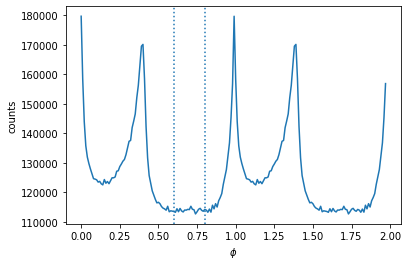

In [36]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

# 读取 HE,ME,LE 的数据
phase = np.array([])
for filename in ["./data/HE/he_screen.fits","./data/ME/me_screen.fits","./data/LE/le_screen.fits"]:
    hdulist = fits.open("./data/HE/he_screen.fits")
    phase = np.append(phase, hdulist[1].data.field("Phase")) #读取Phase
    
phi = np.arange(0,1.99,0.01)[0:-1]
counts,*_ = np.histogram(phase,bins=np.arange(0,1,0.01))
counts = np.append(counts,counts) #产生两个周期
plt.plot(phi,counts)
plt.xlabel("$\phi$")
plt.ylabel("counts")
plt.axvline(x=0.6,ls='dotted')
plt.axvline(x=0.8,ls='dotted')
plt.show()

我们得到了 Crab 脉冲星的双峰轮廓。在做相位分解谱的过程中，我们选择轮廓中“非脉冲相位”的光子作为背景（上图中的0.6-0.8相位），下面开始我们的能谱分析

***

## 能谱分析
我们这一节产生相位分解谱。我们根据上一步产生的轮廓，我们
* 选取“非脉冲相位”光子（0.6-0.8）产生背景能谱
* 产生各个相位的能谱
* 拟合能谱

### 产生“非脉冲相位”光子的能谱
我们选取相位值在0.6-0.8的光子，并产生能谱，作为背景

In [39]:
!fselect ./data/LE/le_screen.fits ./data/LE/le_screen_phase_0.6-0.8.fits expr="Phase>=0.6&&Phase<0.8" clobber=yes

In [40]:
!ls ./data/LE/le_screen_phase_0.6-0.8.fits

./data/LE/le_screen_phase_0.6-0.8.fits


In [59]:
from hxmt_scripts.create_LE_specfile import create_LE_specfile
hdulist = fits.open("./data/LE/le_screen_phase_0.6-0.8.fits")
PI = hdulist[1].data.field("PI")
# 该能谱的曝光时间为总曝光时间的1/5，因为光子为总相位的1/5，
# 我们计算exposure时应除以5
exposure = hdulist[1].header["exposure"]/5
hdulist.close()
# 产生 LE 的能谱的计数
counts,*_ = np.histogram(PI, bins=np.arange(0,1536,1))
error = np.sqrt(counts)
outfile = "./data/LE/le_spec_phase_bkg.pha"
create_LE_specfile(exposure,counts,error,outfile)
# 我们使用 fparkey 工具修改能谱文件中曝光时间的值
fparkey_cmd = "fparkey %s %s EXPOSURE"%(str(exposure),outfile)
!{fparkey_cmd}

我们可以查看我们的输出文件 le_spec_phase_bkg.pha

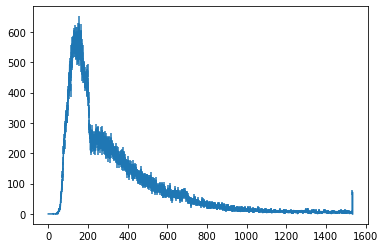

In [51]:
hdulist = fits.open("./data/LE/le_spec_phase_bkg.pha");
channel = hdulist[1].data.field("channel");
counts  = hdulist[1].data.field("counts");
errors  = hdulist[1].data.field("STAT_ERR");
plt.errorbar(channel, counts, yerr=errors);
plt.show()

### 产生各相位的能谱
类似的，我们将完整的相位0-1，分成5个相位区间。产生每个区间的事例文件，产生对应的能谱，并修改能谱文件的曝光时间

In [61]:
!fselect ./data/LE/le_screen.fits ./data/LE/le_screen_phase_0.0-0.2.fits expr="Phase>=0.0&&Phase<0.2" clobber=yes
hdulist = fits.open("./data/LE/le_screen_phase_0.0-0.2.fits")
PI = hdulist[1].data.field("PI")
exposure = hdulist[1].header["exposure"]/5
hdulist.close()
# 产生 LE 的能谱的计数
counts,*_ = np.histogram(PI, bins=np.arange(0,1536,1))
error = np.sqrt(counts)
outfile = "./data/LE/le_spec_phase_0.0-0.2.pha"
create_LE_specfile(exposure,counts,error,outfile)
# 我们使用 fparkey 工具修改能谱文件中曝光时间的值
fparkey_cmd = "fparkey %s %s EXPOSURE"%(str(exposure),outfile)
!{fparkey_cmd}
#-------------------------------


!fselect ./data/LE/le_screen.fits ./data/LE/le_screen_phase_0.2-0.4.fits expr="Phase>=0.2&&Phase<0.4" clobber=yes
hdulist = fits.open("./data/LE/le_screen_phase_0.2-0.4.fits")
PI = hdulist[1].data.field("PI")
# 该能谱的曝光时间为总曝光时间的1/5，因为光子为总相位的1/5，
# 我们计算exposure时应除以5
exposure = hdulist[1].header["exposure"]/5
hdulist.close()
# 产生 LE 的能谱的计数
counts,*_ = np.histogram(PI, bins=np.arange(0,1536,1))
error = np.sqrt(counts)
outfile = "./data/LE/le_spec_phase_0.2-0.4.pha"
create_LE_specfile(exposure,counts,error,outfile)
# 我们使用 fparkey 工具修改能谱文件中曝光时间的值
fparkey_cmd = "fparkey %s %s EXPOSURE"%(str(exposure),outfile)
!{fparkey_cmd}
#-------------------------------


!fselect ./data/LE/le_screen.fits ./data/LE/le_screen_phase_0.4-0.6.fits expr="Phase>=0.4&&Phase<0.6" clobber=yes
hdulist = fits.open("./data/LE/le_screen_phase_0.4-0.6.fits")
PI = hdulist[1].data.field("PI")
# 该能谱的曝光时间为总曝光时间的1/5，因为光子为总相位的1/5，
# 我们计算exposure时应除以5
exposure = hdulist[1].header["exposure"]/5
hdulist.close()
# 产生 LE 的能谱的计数
counts,*_ = np.histogram(PI, bins=np.arange(0,1536,1))
error = np.sqrt(counts)
outfile = "./data/LE/le_spec_phase_0.4-0.6.pha"
create_LE_specfile(exposure,counts,error,outfile)
# 我们使用 fparkey 工具修改能谱文件中曝光时间的值
fparkey_cmd = "fparkey %s %s EXPOSURE"%(str(exposure),outfile)
!{fparkey_cmd}
#-------------------------------


!fselect ./data/LE/le_screen.fits ./data/LE/le_screen_phase_0.8-1.0.fits expr="Phase>=0.8&&Phase<1.0" clobber=yes
hdulist = fits.open("./data/LE/le_screen_phase_0.8-1.0.fits")
PI = hdulist[1].data.field("PI")
# 该能谱的曝光时间为总曝光时间的1/5，因为光子为总相位的1/5，
# 我们计算exposure时应除以5
exposure = hdulist[1].header["exposure"]/5
hdulist.close()
# 产生 LE 的能谱的计数
counts,*_ = np.histogram(PI, bins=np.arange(0,1536,1))
error = np.sqrt(counts)
outfile = "./data/LE/le_spec_phase_0.8-1.0.pha"
create_LE_specfile(exposure,counts,error,outfile)
# 我们使用 fparkey 工具修改能谱文件中曝光时间的值
fparkey_cmd = "fparkey %s %s EXPOSURE"%(str(exposure),outfile)
!{fparkey_cmd}

In [64]:
!ls -tr1 ./data/LE/le_spec_*pha

./data/LE/le_spec_g0_0-94.pha
./data/LE/le_spec_phase_bkg.pha
./data/LE/le_spec_phase_0.0-0.2.pha
./data/LE/le_spec_phase_0.2-0.4.pha
./data/LE/le_spec_phase_0.4-0.6.pha
./data/LE/le_spec_phase_0.8-1.0.pha


我们产生了4个相位的能谱，以及0.6-0.8相位的能谱作为背景能谱，我们下面可以使用 Xspec 拟合能谱

### 能谱拟合

我们在 Xspec 中拟合该能谱（改软件包不包含 Xspec，请自行初始化HEASOFT，并在命令行输入 xspec 进入
Xspec 环境。

`$ xspec `

`		XSPEC version: 12.10.0c`
`	Build Date/Time: Mon Jul  2 19:29:01 2018`

<b>XSPEC12></b> `data ./data/LE/le_spec_phase_0.0-0.2.pha`

<b>XSPEC12></b> `back ./data/LE/le_spec_phase_bkg.pha `

<b>XSPEC12></b> `response ./data/LE/le_rsp.fits`

<b>XSPEC12></b> `cpd /xw`

<b>XSPEC12></b> `ignore **-1.0 10.0-**`

<b>XSPEC12></b> `mo TBabs*pow`

<b>XSPEC12></b> `/*`

<b>XSPEC12></b> `fit`

<b>XSPEC12></b> `setpl rebin 3 15`

<b>XSPEC12></b> `pl ld del`

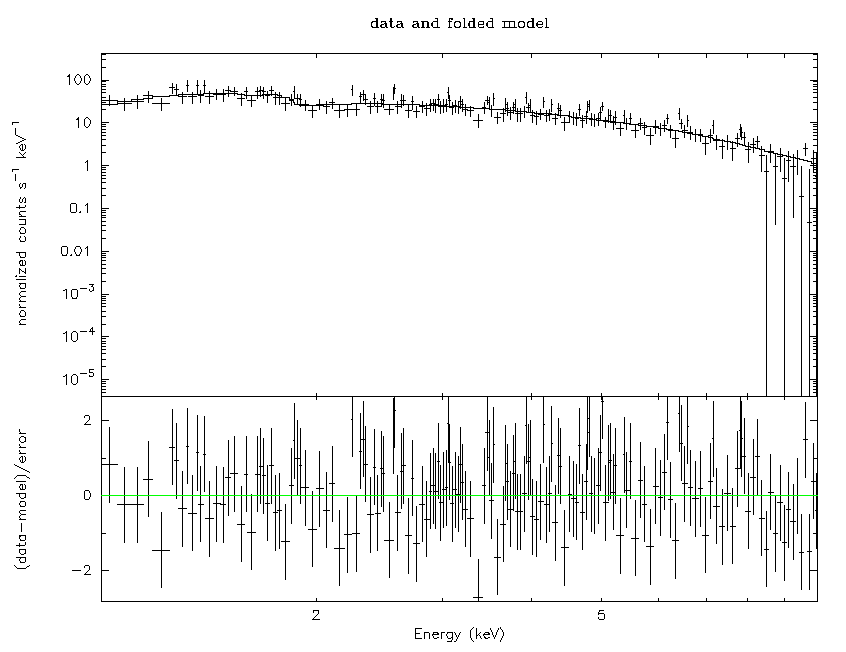

我们可以看到 LE 的拟合结果

`Current model list:`

`========================================================================
Model TBabs<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    0.600477     +/-  0.106388     
   2    2   powerlaw   PhoIndex            1.81481      +/-  8.19737E-02  
   3    2   powerlaw   norm                1.33191      +/-  0.168975     
________________________________________________________________________`

`   Using energies from responses.`

`Fit statistic : Chi-Squared =        1054.35 using 1062 PHA bins.`

`Test statistic : Chi-Squared =        1054.35 using 1062 PHA bins.
 Reduced chi-squared =       0.995606 for   1059 degrees of freedom 
 Null hypothesis probability =   5.345763e-01
 Weighting method: standard`

***

## 结束语

我们由于篇幅受限，仅介绍了 LE 的相位分解谱处理流程，HE 和 ME 的处理过程是类似的，实际情况中，你可以写一个脚本完成这些处理，并对所有的数据做循环操作。具体的处理过程，可以参考我们的文章 

`Ge, M. Y., et al. "X-RAY PHASE-RESOLVED SPECTROSCOPY OF PSRs B0531+ 21, B1509–58, AND B0540–69 WITH RXTE." The Astrophysical Journal Supplement Series 199.2 (2012): 32.`

`Tuo, You-Li, et al. "Insight-HXMT observations of the Crab pulsar." RAA 19.6 (2019): 087.`

如果对处理过程及代码有任何疑问、建议、bug反馈，你可以在该notebook托管的github仓库https://github.com/tuoyl/hxmt_analysis_demo 反馈，欢迎 raise an issue 或是合作。你也可以联系HXMT地面应用系统的老师咨询具体的问题，包括但不限制于数据、软件、探测器、科学。

good luck and have fun!